importing libraries

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

loading train set

In [246]:
train = pd.read_csv("train.csv")
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,408561,8,11,4,10,8,5,6,7,2,...,2,4,6,8,7,6,8,4,8,0.630
1,70143,9,5,3,8,4,3,4,5,5,...,2,4,4,4,4,6,4,6,3,0.515
2,708782,4,6,10,3,5,2,4,2,6,...,4,8,5,4,3,3,2,5,1,0.440
3,572694,5,9,6,8,5,5,2,0,6,...,5,7,8,1,9,4,4,6,6,0.530
4,774181,8,2,3,2,7,7,3,7,5,...,2,2,9,6,8,0,4,8,6,0.530


check are all location ids are unique

In [247]:
duplicates = train[train.duplicated(subset=['id'])]
print(duplicates)

Empty DataFrame
Columns: [id, MonsoonIntensity, TopographyDrainage, RiverManagement, Deforestation, Urbanization, ClimateChange, DamsQuality, Siltation, AgriculturalPractices, Encroachments, IneffectiveDisasterPreparedness, DrainageSystems, CoastalVulnerability, Landslides, Watersheds, DeterioratingInfrastructure, PopulationScore, WetlandLoss, InadequatePlanning, PoliticalFactors, FloodProbability]
Index: []

[0 rows x 22 columns]


as the first column ('id') is categorical, and also it's unique in each row, it can be dropped because it cannot predict the probability

In [248]:
train = train.drop(columns=['id'])

now define a function to fill the missing value by knn imputer algorithm

In [249]:
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))

def knn_imputer_filling(input_data, k = 5):
    missing_data = [input_data.iloc[i] for i in range(len(input_data)) if input_data.iloc[i].isnull().values.any()]
    complete_data = input_data.dropna()
    for i in range(len(missing_data)):
        distances = []
        for j in range(len(complete_data)):
                dist = euclidean_distance(input_data.iloc[i].values, complete_data.iloc[j].values)
                distances.append((dist, j))
        distances.sort()
        nearest_neighbors = distances[:k]
        for col in input_data.columns:
            if np.isnan(input_data.iloc[i][col]):
                knn_sum = 0
                for dist, idx in nearest_neighbors:
                    knn_sum += complete_data.iloc[idx][col]
                missing_data.at[i, col] = knn_sum / len(nearest_neighbors)
    return complete_data.append(missing_data)

the imputer algorithm takes much time so we define a simple filling function that fill with means

In [250]:
def simple_filling(input_data):
    for col in input_data.columns:
        mean_value = input_data[col].mean()
        input_data[col].fillna(mean_value, inplace=True)
    return input_data

fill the missing if found

feature extraction part 1: creating correlation heatmap

In [251]:
correlation_matrix = train.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

KeyboardInterrupt: 

as we saw, there is no correlation between values so we should extract features by multiplying in 'feature.ipynb' notebook

as the 'DeterioratingInfrastructure' times the other column was made a better correlation, we multiply all column to it and insert a 

In [235]:
def add_new_features(input_data, effective_column="DeterioratingInfrastructure"):
    new_data = input_data.copy()
    for col in input_data.columns:
        if col != effective_column and col != "FloodProbability":
            new_data[effective_column + '-' + col] = input_data[col] * input_data[effective_column]
    return new_data

In [236]:
def z_score_scaler(df):
    mean = df.mean()
    std = df.std()
    scaled_df = (df - mean) / std
    return scaled_df, mean, std

def min_max_scaler(df):
    min_val = df.min()
    max_val = df.max()
    scaled_df = (df - min_val) / (max_val - min_val) 
    return scaled_df, min_val, max_val

In [237]:
def create_datasets(input_data):
    if input_data.isnull().values.any():
        input_data = simple_filling(input_data)
        # train = knn_imputer_filling(train, 10)
    train_feature_plus = add_new_features(input_data)
    tfp_z, tpf_z_mean, tpf_z_std = z_score_scaler(train_feature_plus)
    tfp_m, tpf_m_min, tpf_m_max = min_max_scaler(train_feature_plus)
    train_z, train_z_mean, train_z_std = z_score_scaler(input_data)
    train_m, train_m_min, train_m_max = min_max_scaler(input_data)
    return [tfp_z, tfp_m, train_z, train_m], [[tpf_z_mean, tpf_z_std], [tpf_m_min, tpf_m_max], [train_z_mean, train_z_std], [train_m_min, train_m_max]]

In [238]:
datasets, scalers = create_datasets(train)

In [239]:
xs = []
ys = []
for data in datasets:
    y = data['FloodProbability'].to_numpy()
    ys.append(y)
    x = data.drop(['FloodProbability'], axis=1).to_numpy()
    xs.append(x)
xs[0]

array([[ 1.49693007,  2.90124353, -0.46151393, ...,  2.11684195,
         0.24692997,  2.11270462],
       [ 1.98320357,  0.03520959, -0.94413678, ..., -0.5583355 ,
        -0.02047435, -0.8197577 ],
       [-0.44816393,  0.51288191,  2.4342232 , ..., -1.22712987,
        -0.62213407, -1.41957954],
       ...,
       [ 0.03810957, -0.44246274, -1.90938249, ...,  0.37797661,
         0.71488754,  0.71312033],
       [ 0.52438307,  2.4235712 , -0.46151393, ..., -0.29081776,
         0.04637673,  0.04665162],
       [ 0.03810957,  0.99055423, -1.42675964, ..., -0.29081776,
        -0.28787867,  0.71312033]])

In [240]:
xs[1].shape

(838860, 39)

In [241]:
weights = [np.full(xs[i].shape[1], 0.0, dtype=np.float64) for i in range(len(datasets))]
biases = [0.0 for i in range(len(datasets))]
weights

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])]

In [262]:
def linear_regression(epochs_number, initial_learning_rate, intercept, slope, x_train, y_train, momentum=0,
                      patience=np.inf, regularization_param=0, lr_decrease=1, iteration_sample=10000):
    rows, columns = x_train.shape
    mse_serie = []
    mae_serie = []
    learning_rate_serie = []

    # Initialize previous gradients for momentum
    slope_velocity = np.zeros(columns)
    intercept_velocity = 0

    # For early stopping
    best_mse = float('inf')
    patience_counter = 0

    # Initial learning rate
    learning_rate = initial_learning_rate
    total_epoch = epochs_number
    
    # Track per-iteration MSE and MAE for sampling every `iteration_sample` iterations
    mse_per_iteration = []
    mae_per_iteration = []
    sampled_mse = []
    sampled_mae = []
    iteration_counter = 0
    
    for epoch in range(epochs_number):
        total_mse = 0
        total_mae = 0

        for i in range(rows):
            selected_row = x_train[i, :]
            prediction = np.dot(selected_row, slope) + intercept
            real = y_train[i]

            # Calculate gradients with L2 regularization for the slope (not for intercept)
            slope_gradient = selected_row * (prediction - real) * 2 + regularization_param * slope
            intercept_gradient = (prediction - real) * 2

            # Apply momentum
            slope_velocity = momentum * slope_velocity + learning_rate * slope_gradient
            intercept_velocity = momentum * intercept_velocity + learning_rate * intercept_gradient

            # Update parameters
            slope -= slope_velocity
            intercept -= intercept_velocity

            # Calculate errors for MSE and MAE
            iteration_mse = (prediction - real) ** 2
            iteration_mae = abs(prediction - real)
            total_mse += iteration_mse
            total_mae += iteration_mae

            # Store per-iteration errors
            mse_per_iteration.append(iteration_mse)
            mae_per_iteration.append(iteration_mae)

            # Check early stopping and sampling every `iteration_sample` iterations
            if (iteration_counter + 1) % iteration_sample == 0:
                current_sample_mse = np.mean(mse_per_iteration)
                sampled_mse.append(current_sample_mse)
                sampled_mae.append(np.mean(mae_per_iteration))
                mse_per_iteration = []
                mae_per_iteration = []
                
                # Early stopping condition on sample intervals
                if current_sample_mse < best_mse:
                    best_mse = current_sample_mse
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at iteration {iteration_counter + 1} with MSE: {current_sample_mse}")
                        total_epoch = epoch + 1
                        break
                        
            iteration_counter += 1
        
        # Calculate average errors for the epoch
        mse_val = total_mse / rows
        mae_val = total_mae / rows
        mse_serie.append(mse_val)
        mae_serie.append(mae_val)

        # Learning rate decay
        learning_rate *= lr_decrease
        learning_rate_serie.append(learning_rate)

        # Break loop if early stopping was triggered within the iteration loop
        if patience_counter >= patience:
            break
    
    # Plot MSE and MAE over epochs in separate figures
    
    # Combine all plots into a single figure with subplots.
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle("Training Metrics Over Epochs and Iterations")

    # Plot MSE per Epoch
    axs[0, 0].plot(range(total_epoch), mse_serie, label='MSE per Epoch', color='blue')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].set_title('MSE per Epoch')
    axs[0, 0].legend()

    # Plot MAE per Epoch
    axs[0, 1].plot(range(total_epoch), mae_serie, label='MAE per Epoch', color='orange')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].set_title('MAE per Epoch')
    axs[0, 1].legend()

    # Plot Sampled MSE per Iteration
    axs[1, 0].plot(range(len(sampled_mse)), sampled_mse, label=f'MSE (Sampled every {iteration_sample} Iterations)', color='purple')
    axs[1, 0].set_xlabel(f'Sample Interval ({iteration_sample} Iterations)')
    axs[1, 0].set_ylabel('Sampled MSE')
    axs[1, 0].set_title(f'Sampled MSE per {iteration_sample} Iterations')
    axs[1, 0].legend()

    # Plot Sampled MAE per Iteration
    axs[1, 1].plot(range(len(sampled_mae)), sampled_mae, label=f'MAE (Sampled every {iteration_sample} Iterations)', color='green')
    axs[1, 1].set_xlabel(f'Sample Interval ({iteration_sample} Iterations)')
    axs[1, 1].set_ylabel('Sampled MAE')
    axs[1, 1].set_title(f'Sampled MAE per {iteration_sample} Iterations')
    axs[1, 1].legend()

    # Plot Learning Rate over Epochs
    axs[2, 0].plot(range(total_epoch), learning_rate_serie, label='Learning Rate per Epoch', color='red')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].set_ylabel('Learning Rate')
    axs[2, 0].set_title('Learning Rate per Epoch')
    axs[2, 0].legend()

    # Remove the empty subplot
    fig.delaxes(axs[2, 1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return slope, intercept


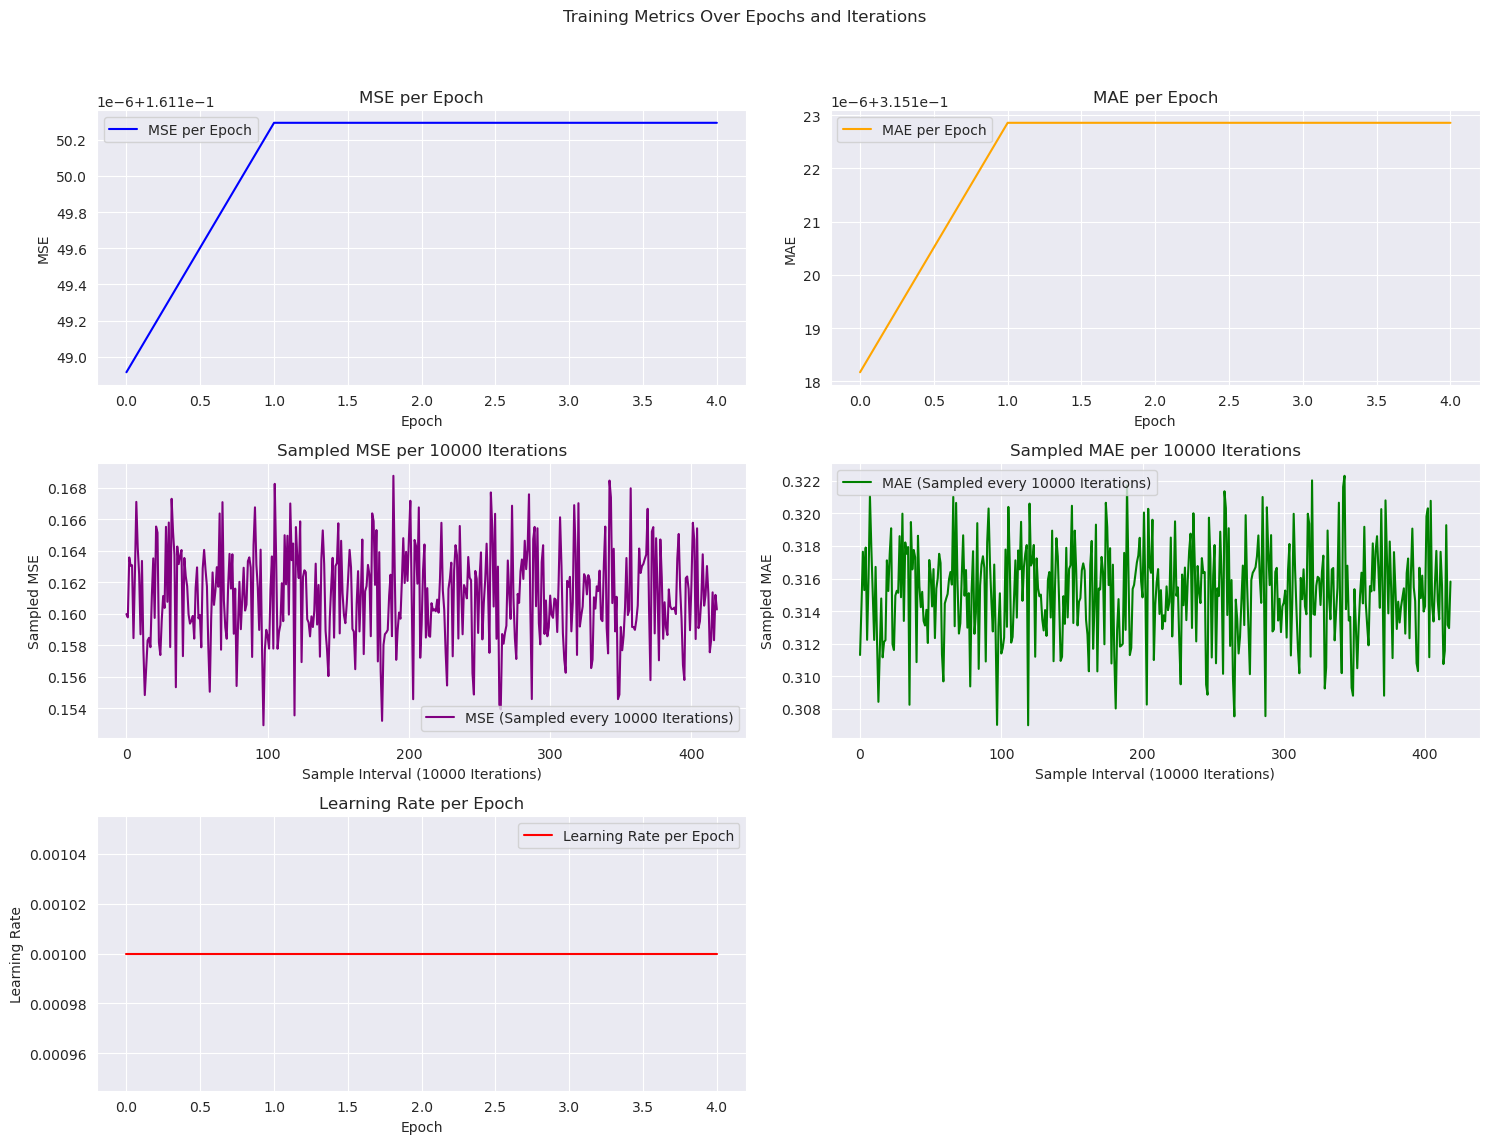

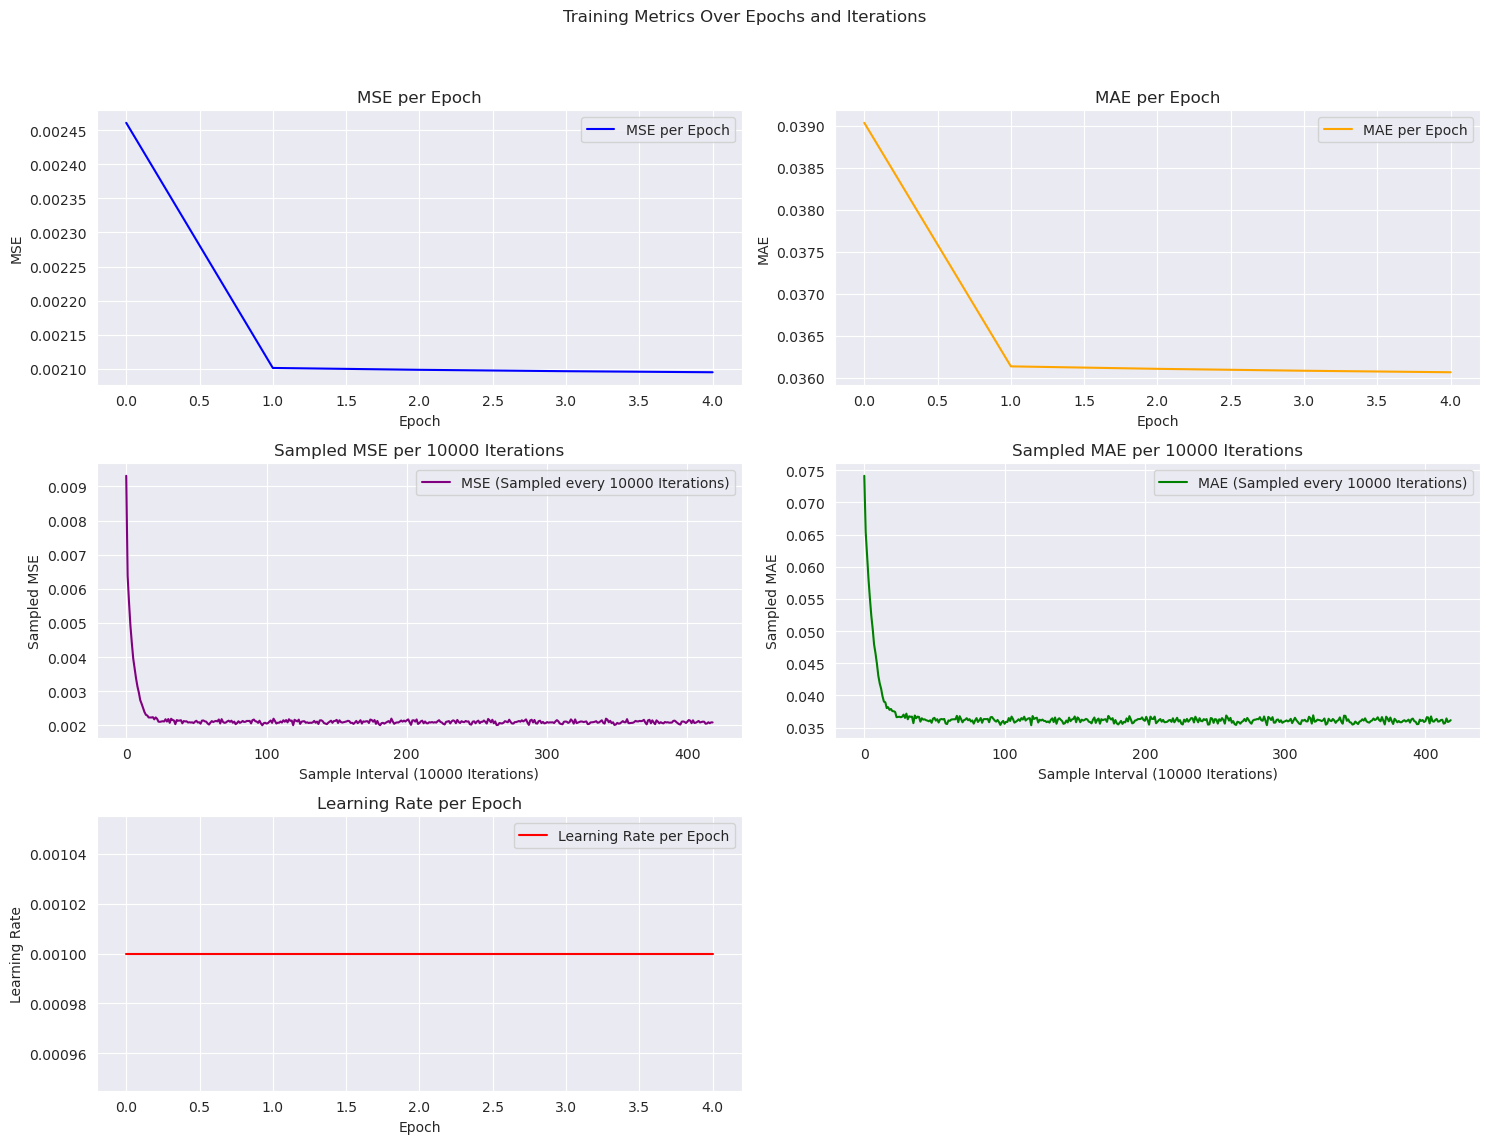

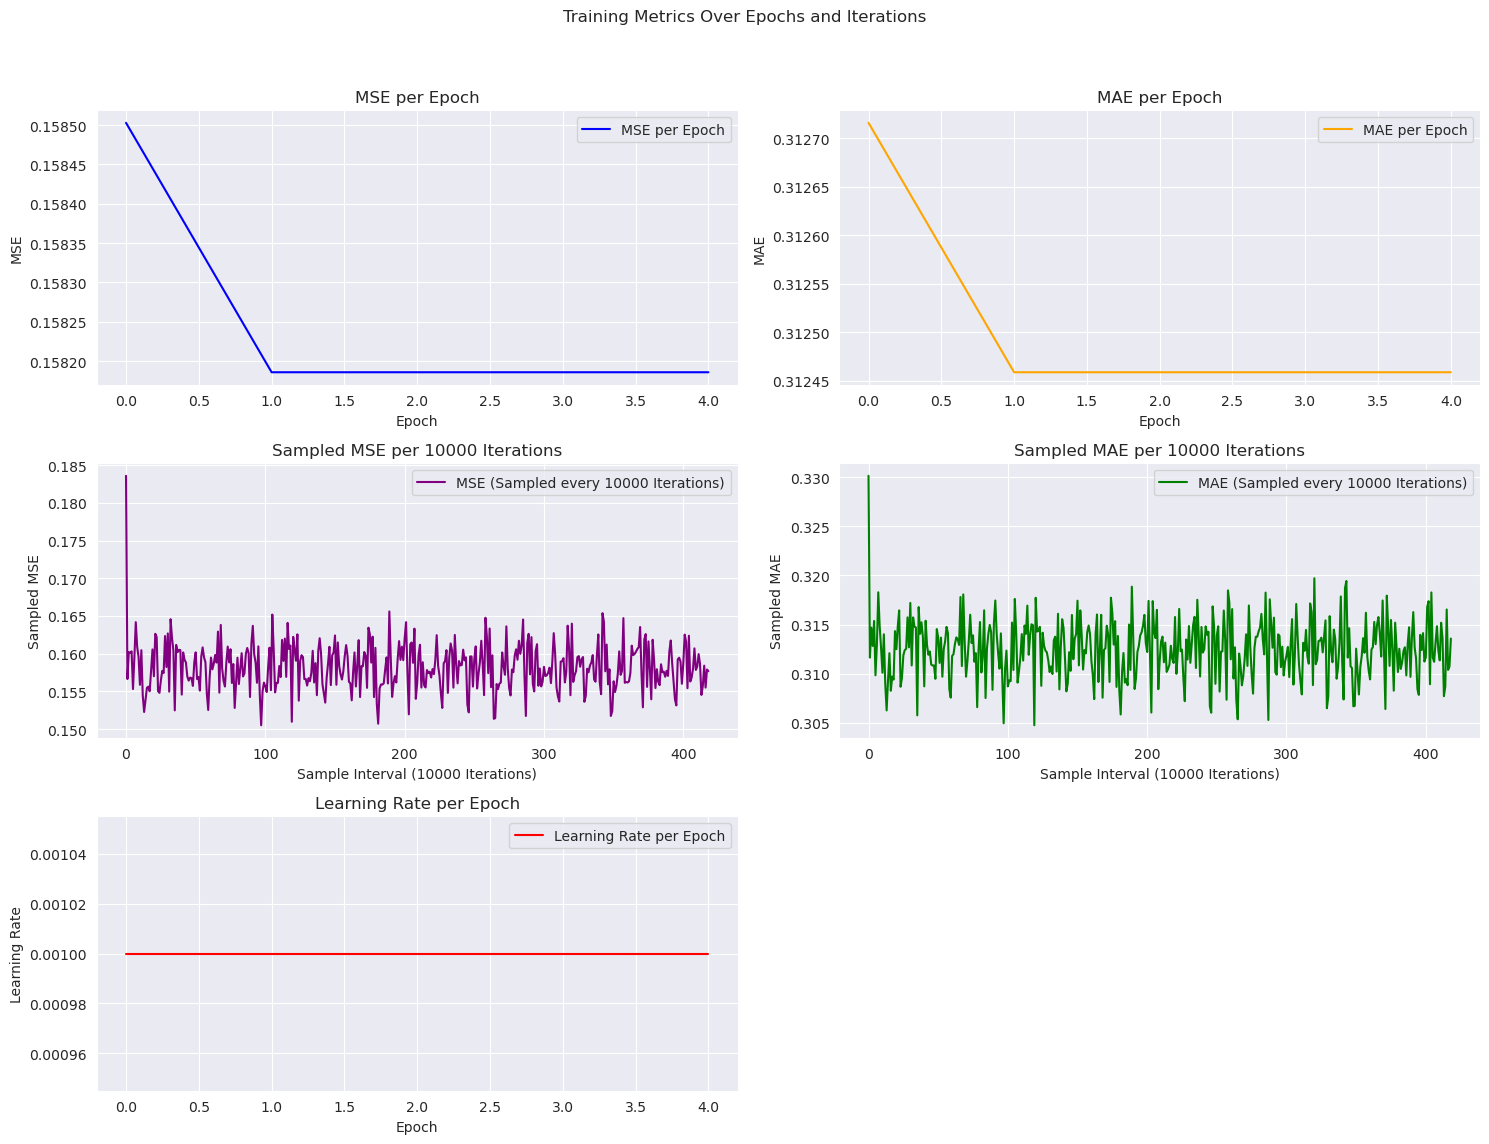

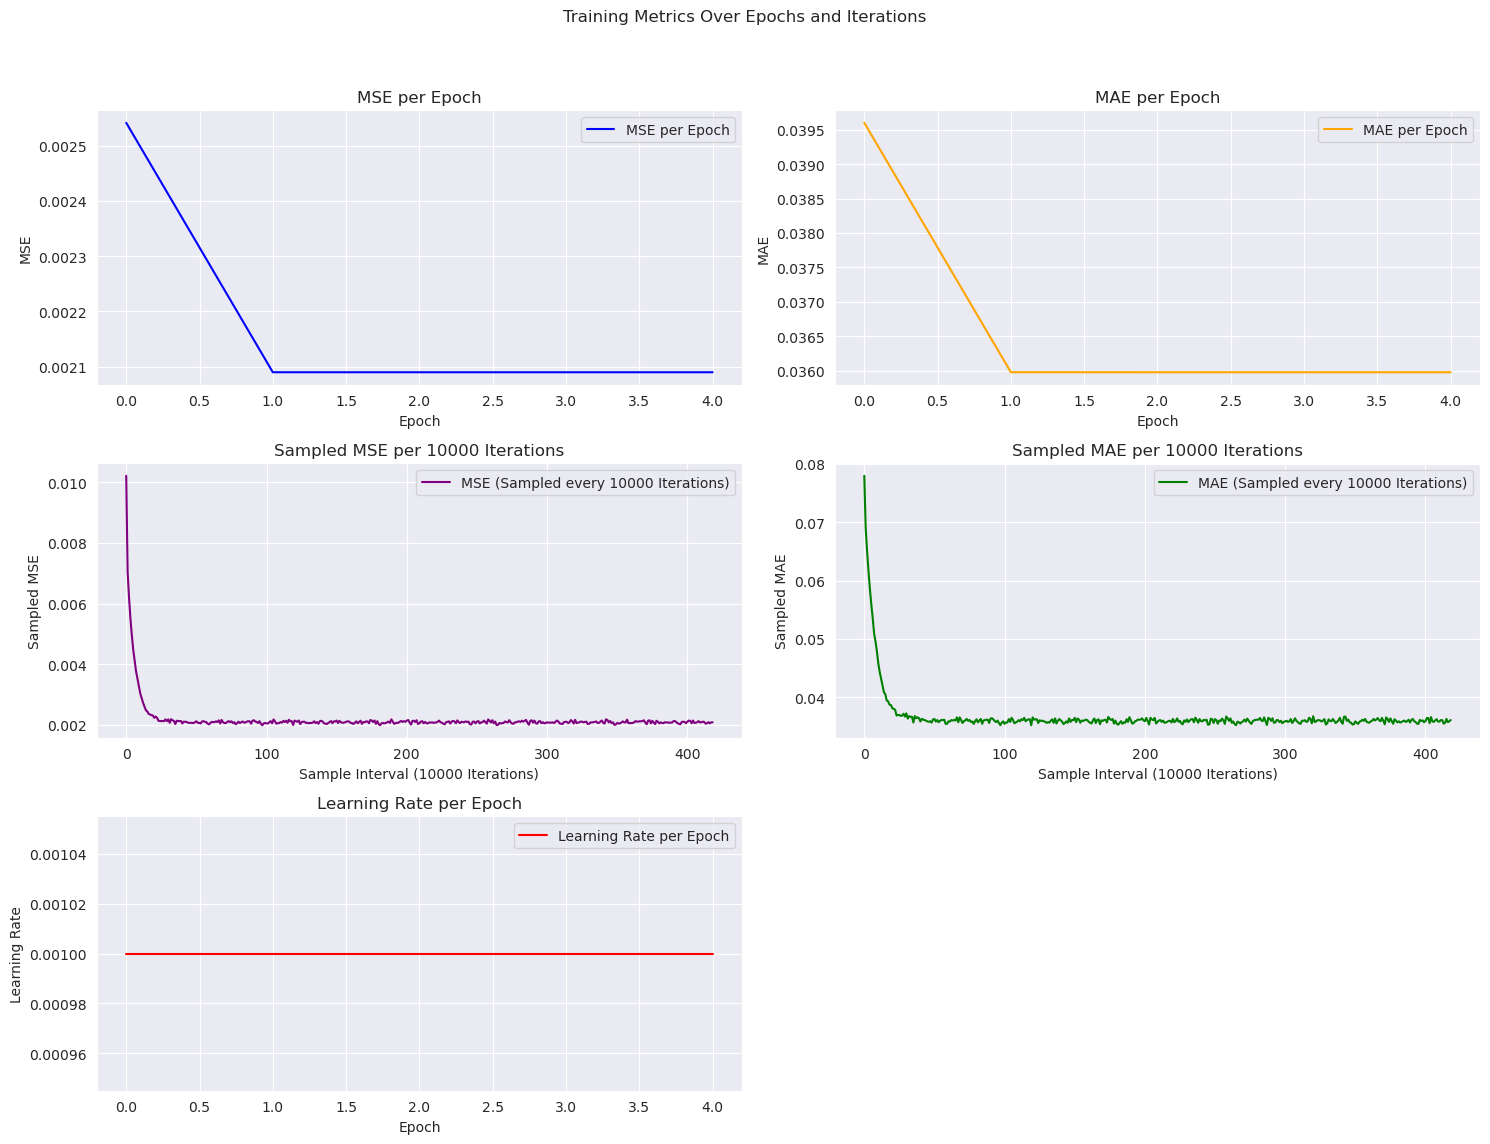

In [266]:
epochs = 5
result_w = weights.copy()
result_b = biases.copy()
for i in range(len(datasets)):
    result_w[i], result_b[i] = linear_regression(epochs, 0.001, biases[i], weights[i], xs[i], ys[i])

In [190]:

result_w

[array([ 0.2102989 ,  0.23254987,  0.21548071,  0.23530663,  0.21209081,
         0.20150298,  0.20177534,  0.21375372,  0.22031919,  0.22648958,
         0.23056671,  0.24551717,  0.22517484,  0.23944579,  0.21481058,
         0.0983335 ,  0.23213905,  0.21643829,  0.23309227,  0.22312848,
         0.0153649 ,  0.03010278,  0.00623355,  0.01069846, -0.00529337,
         0.04028968,  0.01013766, -0.00398844,  0.00814002,  0.03426638,
        -0.0100868 ,  0.01628318,  0.00595954, -0.01206651,  0.00127698,
         0.01656679,  0.02419751,  0.01954387, -0.00343125]),
 array([ 0.18882485,  0.21697202,  0.19336662,  0.20454979,  0.20269831,
         0.20234279,  0.19016034,  0.19027327,  0.19029779,  0.21392079,
         0.19069427,  0.20275564,  0.20039865,  0.19191781,  0.19146225,
        -0.07077535,  0.21708751,  0.19848862,  0.19138729,  0.1884767 ,
         0.03186156,  0.033508  ,  0.02975649,  0.03468936,  0.03456777,
         0.03491277,  0.02658187,  0.03671942,  0.03108001,  0

In [191]:
def predict(x_test, y_test, slope, intercept):
    y_predicted = np.dot(x_test, slope) + intercept
    mse = np.mean((y_test - y_predicted) ** 2)
    mae = np.mean(np.abs(y_test - y_predicted))
    r2 = 1 - (np.sum((y_test - y_predicted) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")
    return y_predicted

In [267]:
predicted = []
for i in range(len(datasets)):
    predicted.append(predict(xs[i], ys[i], result_w[i], result_b[i]))


Mean Absolute Error: 0.31368817871355237
Mean Squared Error: 0.15930465762198415
R2 Score: 0.8406951524713161
Mean Absolute Error: 0.03598586064036507
Mean Squared Error: 0.0020878498950610952
R2 Score: 0.8448550590328677
Mean Absolute Error: 0.31178655014431156
Mean Squared Error: 0.15734512643213835
R2 Score: 0.8426546859971142
Mean Absolute Error: 0.035910863888456705
Mean Squared Error: 0.0020846426655135365
R2 Score: 0.8450933833683485


In [193]:
test = pd.read_csv("test.csv")
test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,781974,4,3,5,6,3,2,10,3,3,...,5,6,4,5,2,3,5,5,8,0.505
1,937737,7,3,5,1,3,7,3,2,3,...,8,4,4,6,7,2,6,6,4,0.470
2,907828,4,3,3,5,4,5,4,4,3,...,4,8,5,6,5,8,7,7,4,0.490
3,784628,5,7,6,5,3,6,6,4,9,...,5,4,5,8,12,7,5,4,4,0.610
4,662460,10,2,4,3,5,3,3,7,7,...,4,3,6,6,6,6,7,6,6,0.540


In [194]:
test = test.drop(columns=['id'])


In [195]:
def z_score_scaler_test(input_data, mean, std):
    scaled_df = (input_data - mean) / std
    return scaled_df

def min_max_scaler_test(input_data, min_val, max_val):
    scaled_df = (input_data - min_val) / (max_val - min_val) 
    return scaled_df

In [196]:

def create_test_datasets(input_data, scaler):
    if input_data.isnull().values.any():
        input_data = simple_filling(input_data)
        # train = knn_imputer_filling(train, 10)
    train_feature_plus = add_new_features(input_data)
    tfp_z = z_score_scaler_test(train_feature_plus, scaler[0][0], scaler[0][1])
    tfp_m = min_max_scaler_test(train_feature_plus, scaler[1][0], scaler[1][1])
    train_z = z_score_scaler_test(input_data, scaler[2][0], scaler[2][1])
    train_m = min_max_scaler_test(input_data,scaler[3][0], scaler[3][1])
    return [tfp_z, tfp_m, train_z, train_m]

In [197]:
test_datasets = create_test_datasets(test, scalers)
print(test_datasets)
xs_test = []
ys_test = []
for data in test_datasets:
    y = data['FloodProbability'].to_numpy()
    ys_test.append(y)
    x = data.drop(['FloodProbability'], axis=1).to_numpy()
    xs_test.append(x)

[        MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0              -0.448164           -0.920135         0.021109       0.514933   
1               1.010657           -0.920135         0.021109      -1.920882   
2              -0.448164           -0.920135        -0.944137       0.027770   
3               0.038110            0.990554         0.503732       0.027770   
4               2.469477           -1.397807        -0.461514      -0.946556   
...                  ...                 ...              ...            ...   
209710         -0.448164            0.512882        -0.461514      -0.459393   
209711          0.524383            0.035210        -1.909382       0.514933   
209712          1.010657            0.512882        -0.461514       0.514933   
209713          1.010657           -0.442463         0.021109       0.027770   
209714         -0.448164            0.035210         1.468977      -0.459393   

        Urbanization  ClimateChange  D

In [200]:
predicted_test = []
for i in range(len(datasets)):
    predicted_test.append(predict(xs_test[i], ys_test[i], result_w[i], result_b[i]))

Mean Absolute Error: 0.31429430780462186
Mean Squared Error: 0.15990997244596597
R2 Score: 0.839718589887849
Mean Absolute Error: 0.036034161275208226
Mean Squared Error: 0.0020939675495502044
R2 Score: 0.8440392259660622
Mean Absolute Error: 0.3122935770427608
Mean Squared Error: 0.15784894281081954
R2 Score: 0.8417844068669359
Mean Absolute Error: 0.03595022487165275
Mean Squared Error: 0.002089504719597371
R2 Score: 0.8443716219547084


Early stopping at iteration 340000 with MSE: 0.15970762759555374


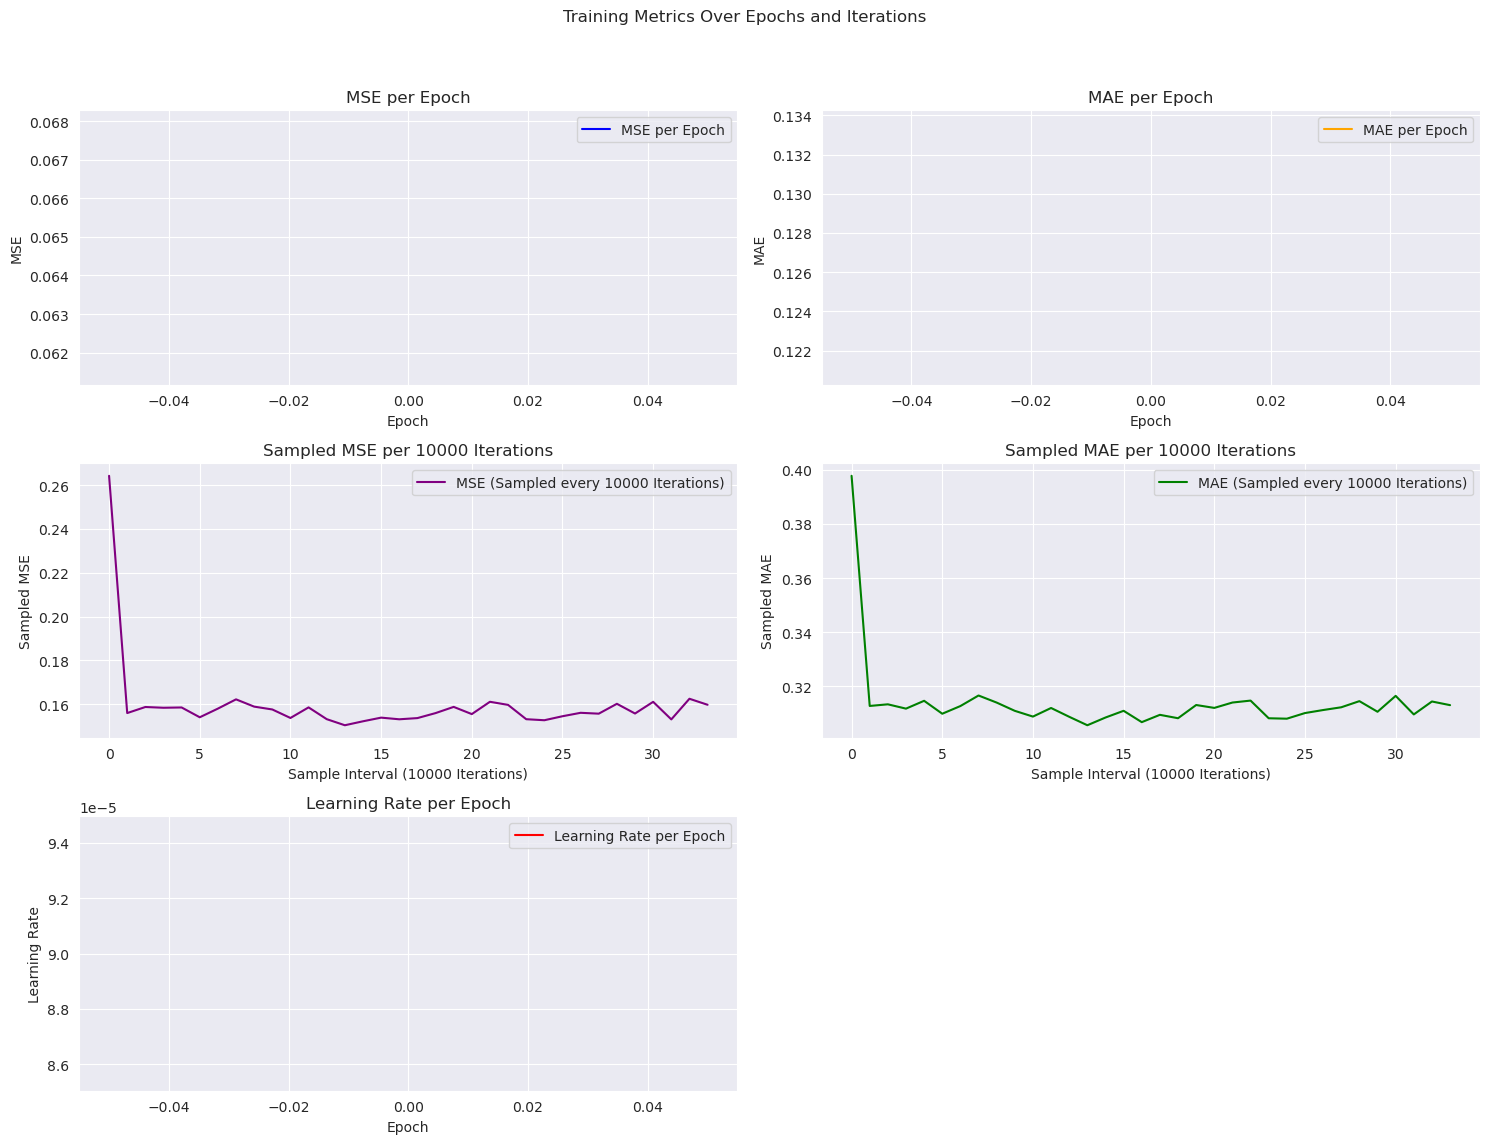

Early stopping at iteration 1180000 with MSE: 0.0021721710452656936


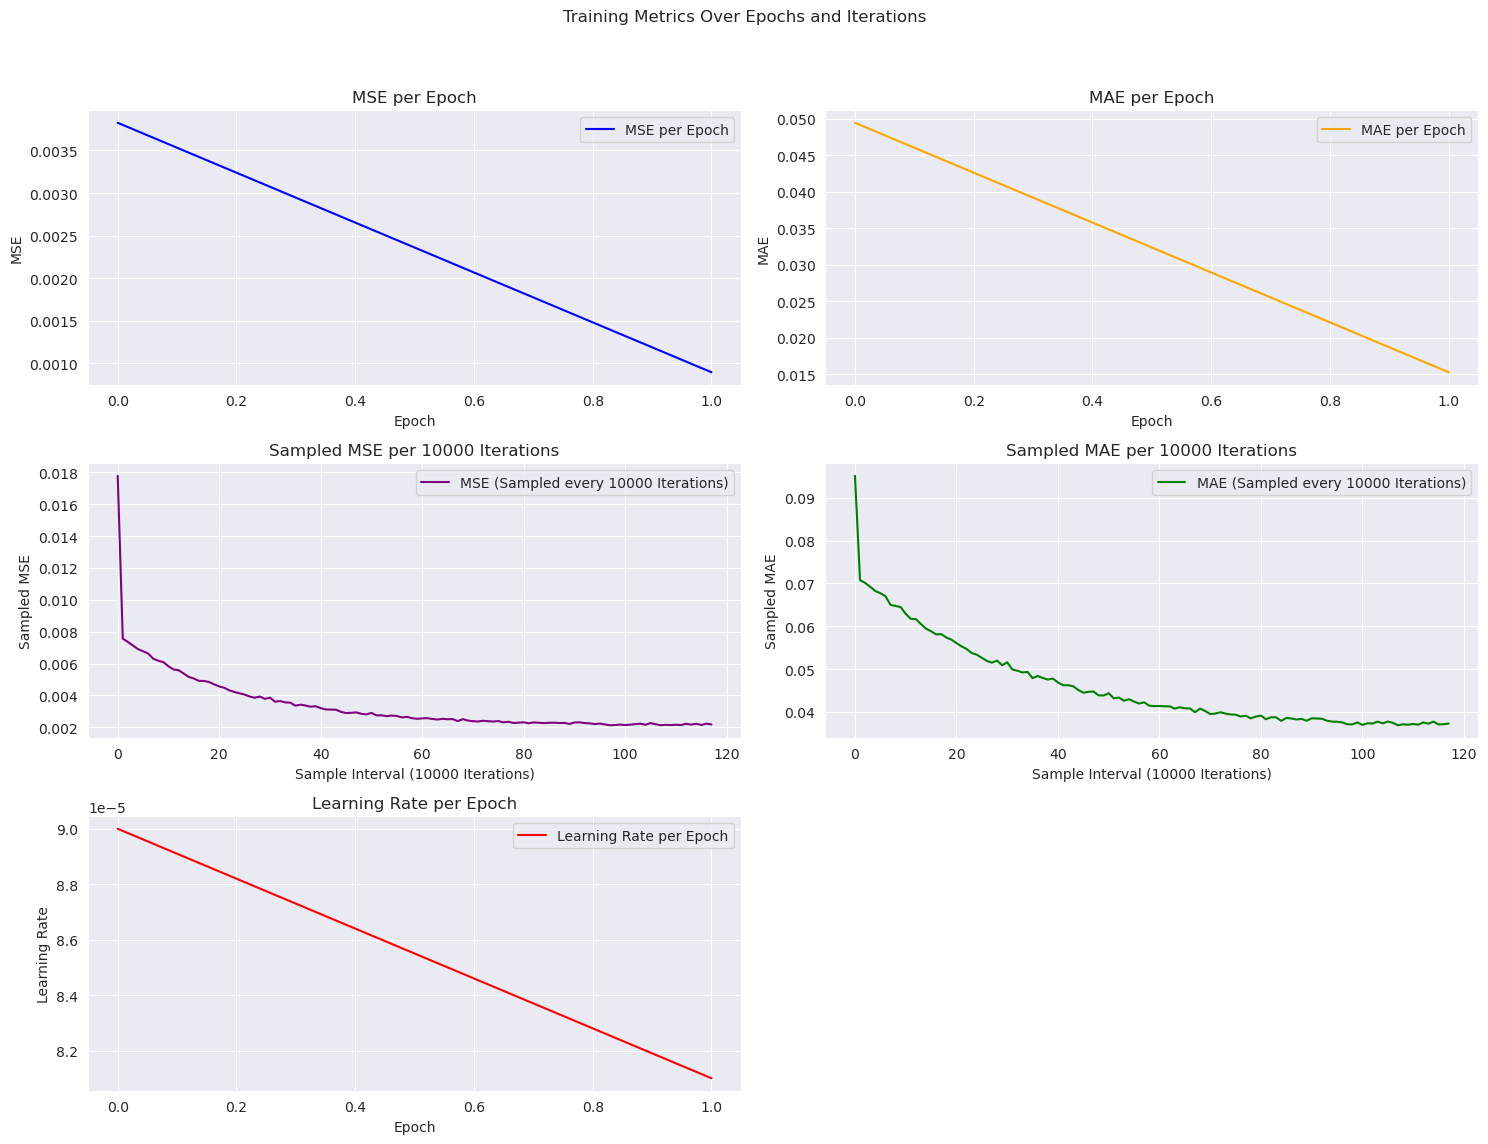

Early stopping at iteration 340000 with MSE: 0.159152463285957


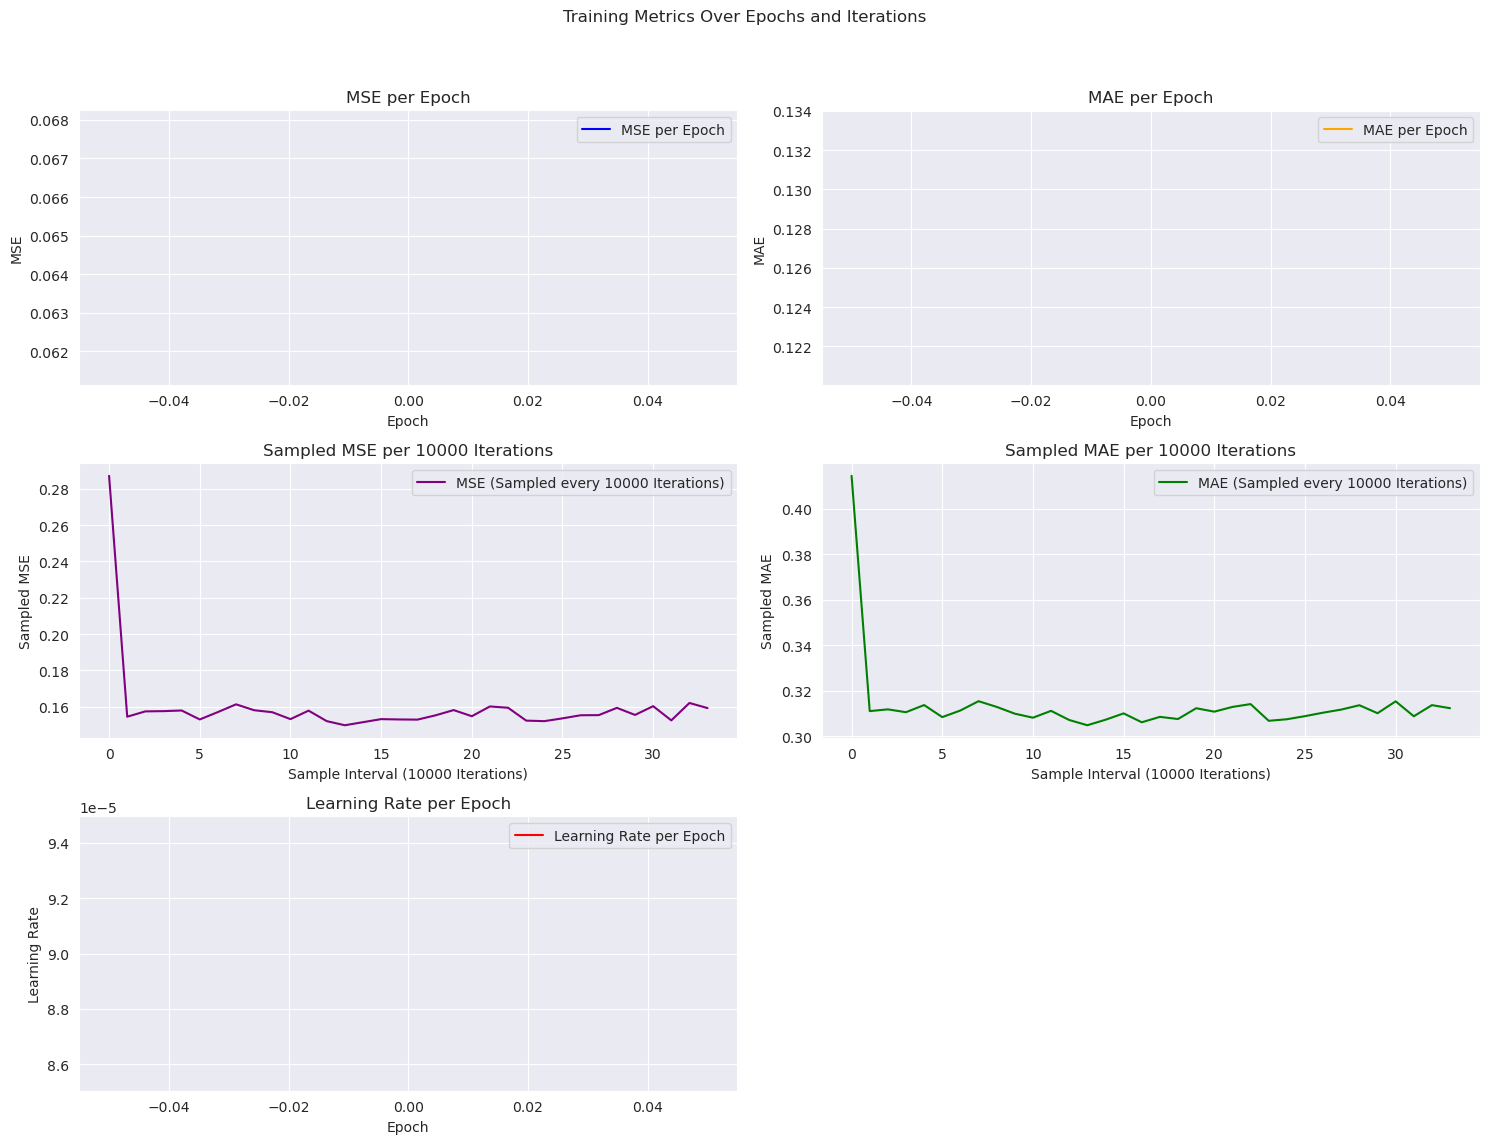

Early stopping at iteration 2020000 with MSE: 0.0021642139898867033


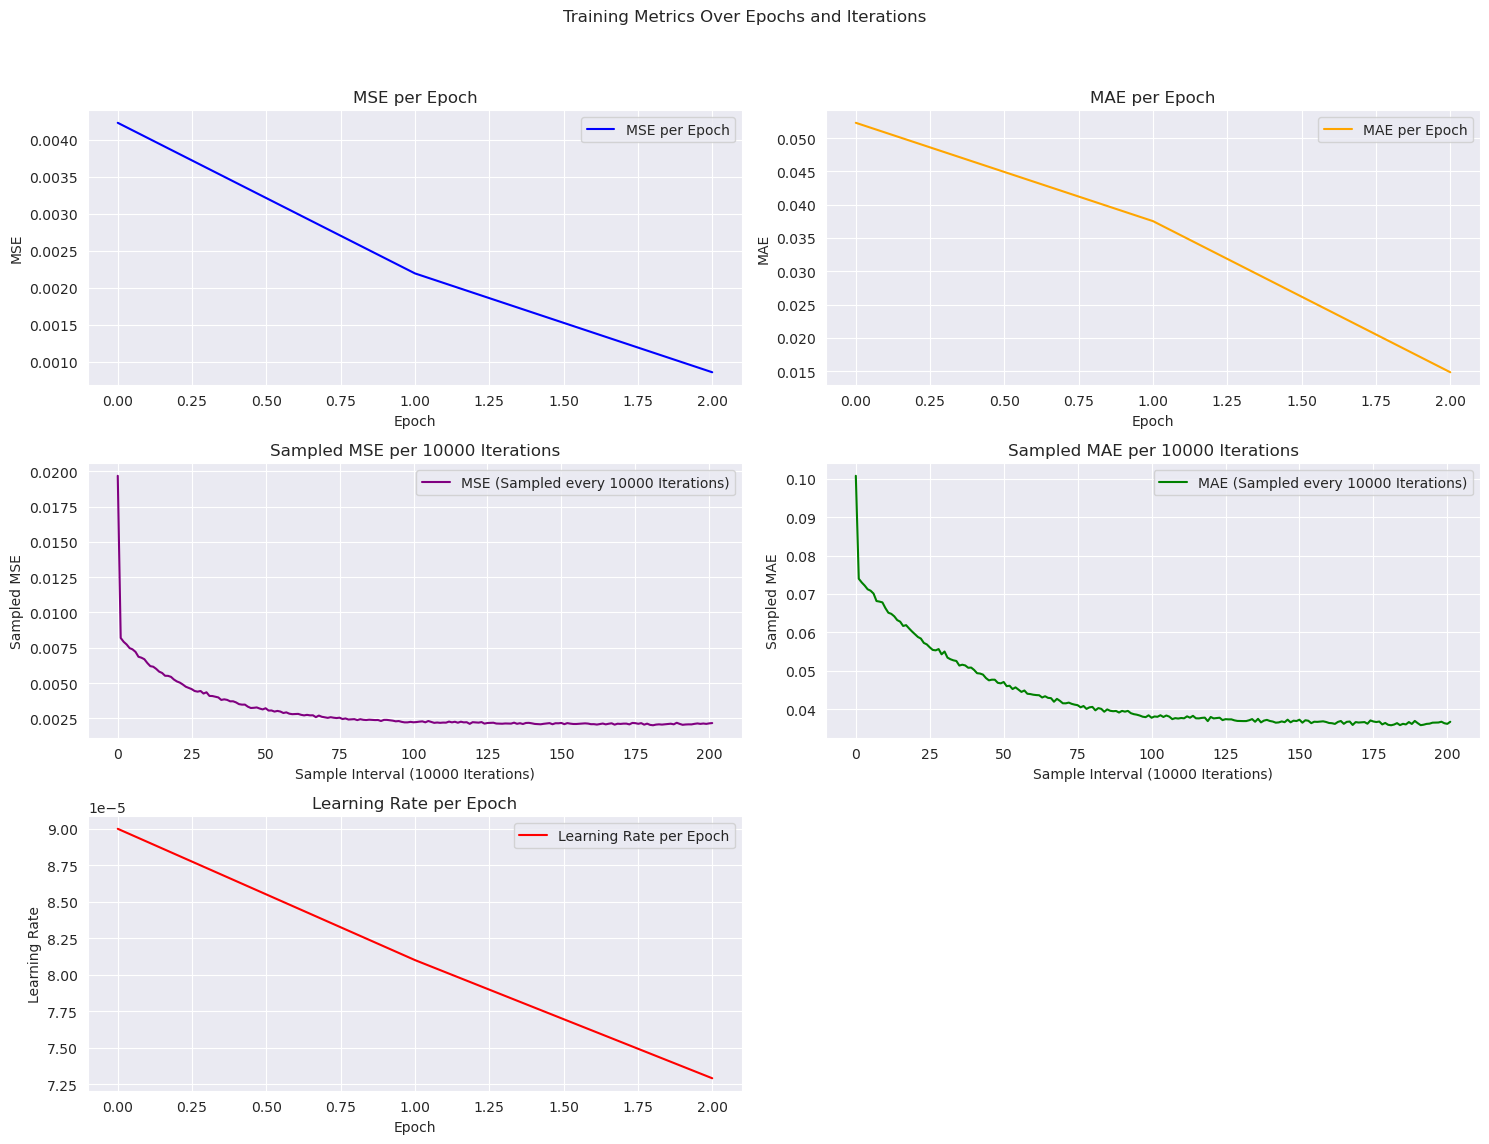

Mean Absolute Error: 0.3111713597913853
Mean Squared Error: 0.15617582693310406
R2 Score: 0.8434614090454704
Mean Absolute Error: 0.0370951714570324
Mean Squared Error: 0.0021545941403754636
R2 Score: 0.8395236975214226
Mean Absolute Error: 0.31050607635537963
Mean Squared Error: 0.1556652896095394
R2 Score: 0.8439731322412422
Mean Absolute Error: 0.03638243786259979
Mean Squared Error: 0.002097174221555909
R2 Score: 0.8438003898636641


In [268]:
weights2 = [np.full(xs[i].shape[1], 0.0, dtype=np.float64) for i in range(len(datasets))]
biases2 = [0.0 for i in range(len(datasets))]

epochs = 20
result_w2 = weights2.copy()
result_b2 = biases2.copy()
for i in range(len(datasets)):
    result_w2[i], result_b2[i]= linear_regression(epochs_number=epochs, initial_learning_rate=0.0001, intercept=biases2[i], slope=weights2[i], x_train=xs[i], y_train=ys[i], momentum=0.5, patience=20, regularization_param=0.0, lr_decrease=.90, iteration_sample=10000)
    

predicted_test2 = []
for i in range(len(datasets)):
    predicted_test2.append(predict(xs_test[i], ys_test[i], result_w2[i], result_b2[i]))